In [1]:
from colorsys import hsv_to_rgb
from IPython.display import HTML
import matplotlib.pyplot as plt

import numpy as np
import jax.random as jr
from sklearn.decomposition import PCA

from src.model.nca import GrowingNCA, SteerableNCA
from src.utils import load_pytree
from src.visualisation.utils import plot_img, plot_dev_path

In [12]:
# # nca = GrowingNCA((64, 64), num_dev_steps=(48, 96), key=jr.key(42))
# # nca = load_pytree('data/examples/', 'model_01', nca)
# nca = SteerableNCA((64, 64), num_dev_steps=(48, 96), key=jr.key(42))
# # nca = load_pytree('data/examples/', 'steerable-rotated', nca)
# # nca = load_pytree('data/examples/', 'steerable-rotated-same-dir', nca)
# nca = load_pytree('data/examples/', 'steerable-same-emb-opposing-dir', nca)

baseline = SteerableNCA(
    (64,64),
    rgb_init = 'angle_based',
    hidden_init = 'constant',
    initial_angle= 'value',
    num_dev_steps=(48, 96),
    key=jr.key(42)
)
baseline = load_pytree('data/logs/morpho_0/steerable_baseline/', 'checkpoint', baseline)

same = SteerableNCA(
    (64,64),
    rgb_init = 'none',
    hidden_init = 'constant',
    initial_angle= 'radial',
    num_dev_steps=(48, 96),
    key=jr.key(42)
)
same = load_pytree('data/logs/morpho_0/steerable_same_init/', 'checkpoint', same)

rotated = SteerableNCA(
    (64,64),
    rgb_init = 'none',
    hidden_init = 'constant',
    initial_angle= 'radial',
    num_dev_steps=(48, 96),
    key=jr.key(42)
)
rotated = load_pytree('data/logs/morpho_0/steerable_opposite_dir/', 'checkpoint', rotated)

In [14]:
output, dev_path = same(jr.key(42), steps=96)
# plot_img(output);
ani = plot_dev_path(dev_path[:, :4]);
HTML(ani.to_jshtml())

In [33]:
S, C, H, W = dev_path.shape
all_cell_states = dev_path.transpose(0, 2, 3, 1).reshape(S * H * W, C)
alive_idx = np.nonzero(all_cell_states[:, 3:4])
print(len(alive_idx[0]))
alive = all_cell_states[alive_idx[0]]

pca = PCA(n_components=None, whiten=True, power_iteration_normalizer='auto')
alive_pca = pca.fit_transform(alive[..., 4:-1])

17097


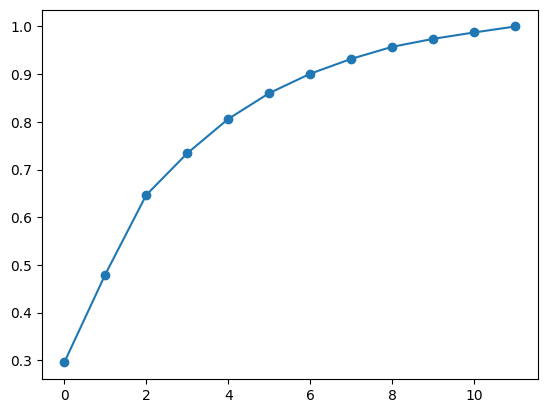

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o');

In [26]:
alive_pca = (alive_pca - alive_pca.min()) / (alive_pca.max() - alive_pca.min())

path_pca = np.zeros((len(all_cell_states), 3))
path_pca[alive_idx[0]] = alive_pca
# all_states_pca = all_states_pca.reshape(S, H, W, 3)

path_pca_image = path_pca.reshape(S, H, W, 3).transpose(0, 3, 1, 2)
ani = plot_dev_path(path_pca_image);
HTML(ani.to_jshtml())
# c = np.array([hsv_to_rgb(h, 1.0, 1.0) for h in path_pca[:, 0]])
# c = c.reshape(S, H, W, 3).transpose(0, 3, 1, 2)
# ani = plot_dev_path(c);
# HTML(ani.to_jshtml())

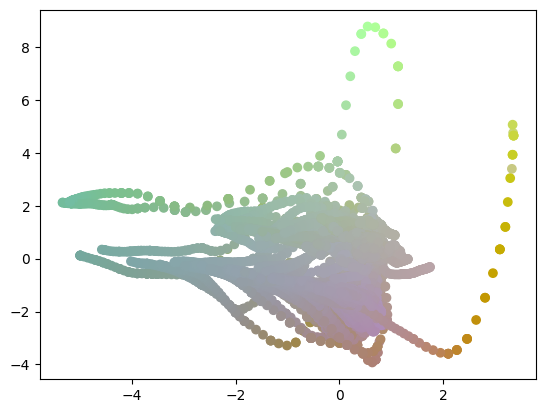

In [23]:
import matplotlib.pyplot as plt

pca = PCA(n_components=2, whiten=True)
position_pca = pca.fit_transform(alive[..., 4:])
plt.scatter(position_pca[:, 0], position_pca[:, 1], c=alive_pca)